<a href="https://colab.research.google.com/github/fralfaro/MAT281_2023/blob/main/homeworks/h1/hw_01.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto de MAT281

* __Nombre__: Ignacio Allendes

* __Rol__: 202004531-3


## Desarrollo tecnico del desafio "Titanic 2912"


<img src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg" width = "400" align="center"/>



## Librerias y carga de datos

In [89]:
## base imports ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Set ggplot styles and update Matplotlib with them.
ggplot_styles = {
    'axes.grid': False
}

plt.rcParams.update(ggplot_styles)

import warnings; warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)

import re
from sklearn.model_selection import train_test_split
# Scaler y Encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# Crossvalidation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Gridsearch
from sklearn.model_selection import GridSearchCV
# metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Visualizacion
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image as PImage
import collections
from sklearn.decomposition import PCA

In [90]:
## cargando los datos ##
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/DatosProyectoAplica/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
sample_submission_df = pd.read_csv(path+"sample_submission.csv") #este es un ejemplo de submission
test_df = pd.read_csv(path+"test.csv") #datos a testear
train_df = pd.read_csv(path+"train.csv") #datos para entrenar

## Definición del problema

Estamos ante un problema de clasificación, es decir, dado cierto dato con atributos, hay que clasificarlo en alguna de las dos clases: Transportado o No Transportado.

Los atributos son:
* PassengerId: Una identificación única para cada pasajero. Cada ID toma el formato gggg_pp donde gggg indica un grupo con el que viaja el pasajero y pp es su número dentro del grupo. Las personas de un grupo suelen ser miembros de la familia, pero no siempre.
* HomePlanet: El planeta del que partió el pasajero
* CryoSleep: Indica si el pasajero eligió ser puesto en animación suspendida durante la duración del viaje.
* Cabin: El número de cabina donde se hospeda el pasajero. En forma deck/num/side.
* Destination: El planeta al que desembarcará el pasajero.
* Age: La edad
* VIP: Si el pasajero ha pagado por un servicio VIP especial durante el viaje.
* RoomService, ShoppingMall, Spa y VRDeck: son los montos que el pasajero ha facturado en cada una de las muchas comodidades de lujo del Spaceship Titanic.
* Name: El nombre del pasajero

## Estadistica descriptiva

Primero, notemos que tenemos NaNs dispersos casi uniformemente por cada atributo, estos casos los trataremos despues.

In [92]:
print('train_df:')
print(train_df.isna().sum())
print('\n')
print('test_df:')
print(test_df.isna().sum())

train_df:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


test_df:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Veamos un poco de estadistica

In [93]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Tambien, vemos que el test y train tienen estadisticas parecidas.

In [94]:
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


Lo primero que llama la atencion es que en RoomService, FoodCourt, ShoppingMall, Spa y VRDeck, su 75% de datos es del orden de 50 pero su media es 300 y sus valores maximos son del orden de 10000. Por ende, podemos asumir que hay outlayers.

Para visualizar mejor las distribuciones de datos, en la siguiente sección las graficaremos.

## Visualización descriptiva

Primero, veamos a los atributos continuos

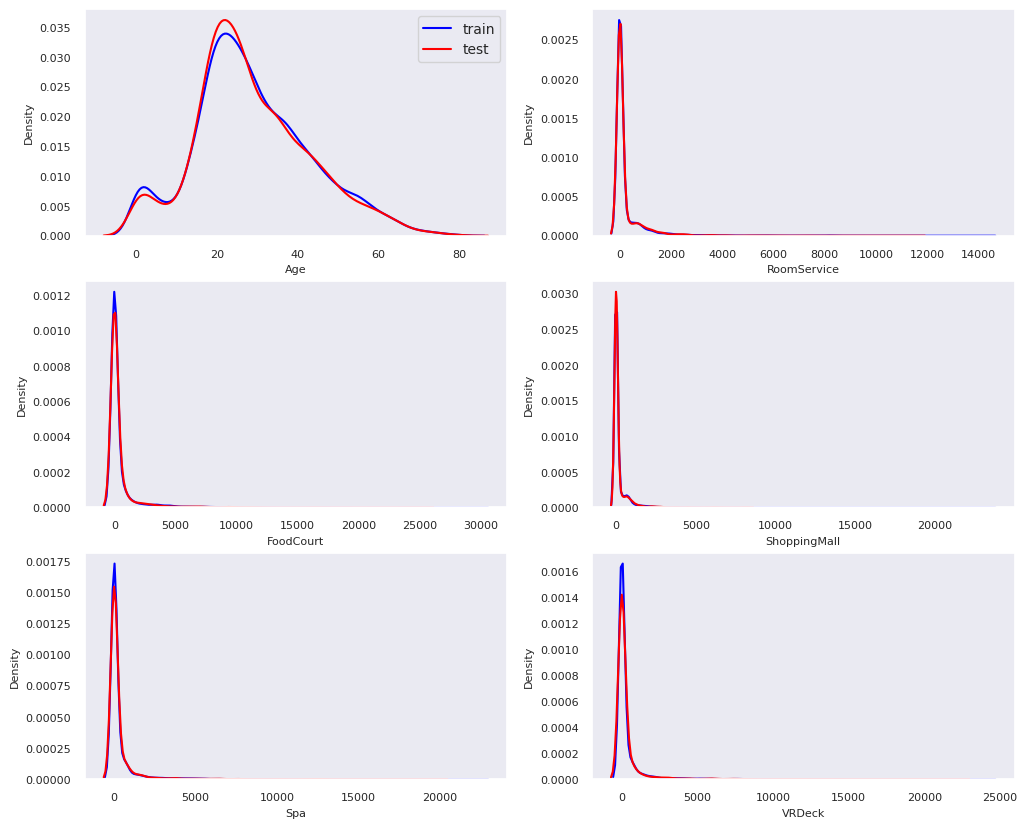

In [95]:
continuous_features = ['Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
fig, ax = plt.subplots(figsize=(12,10), nrows=3, ncols=2)
contador = 0
for i in range(3):
  for j in range(2):
    col = continuous_features[contador]
    sns.kdeplot(train_df.drop('Transported',axis=1), x=col, ax=ax[i,j], color='blue', label='train')
    sns.kdeplot(test_df, x=col, ax=ax[i,j], color='red', label='test')
    contador+=1

ax[0,0].legend()
plt.savefig('continuos',dpi=300,bbox_inches='tight')

Ahora los categoricos

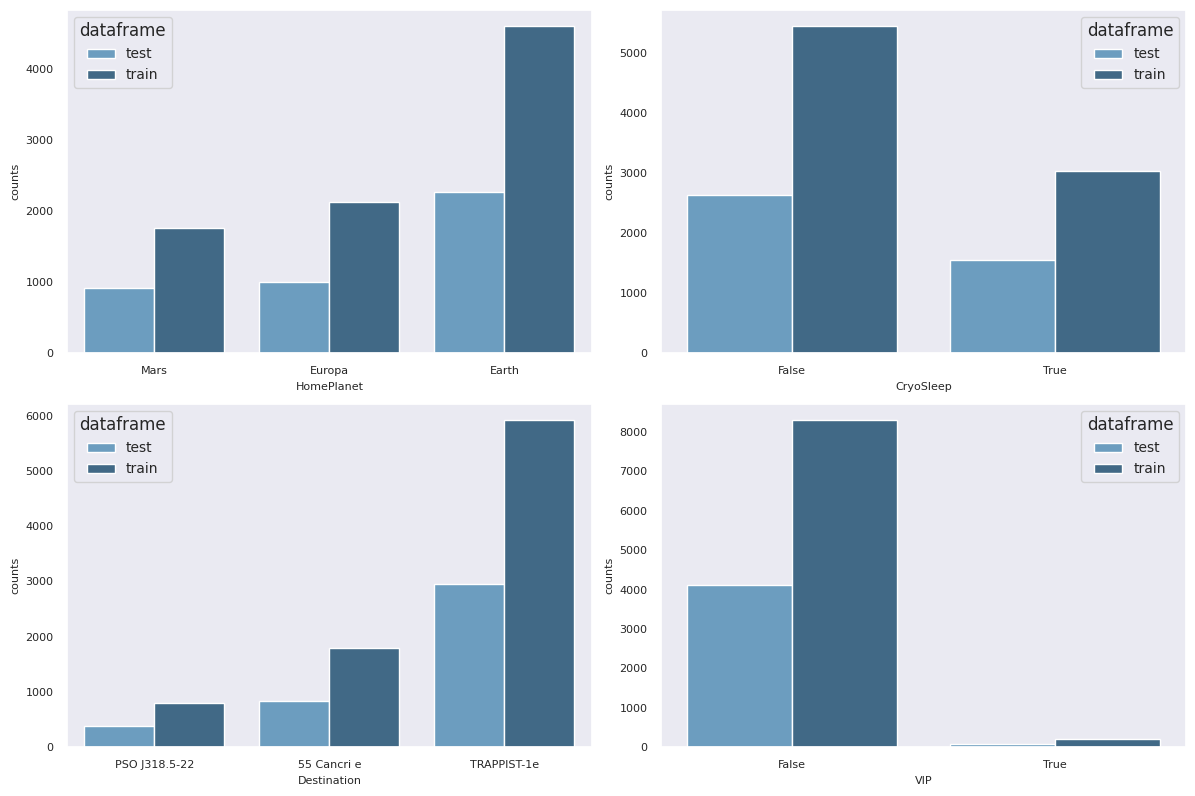

In [96]:
cat_feats = ['HomePlanet','CryoSleep','Destination','VIP']
cont=0
fig, axes = plt.subplots(figsize=(12,8), nrows=2, ncols=2)

x = (train_df.drop('Transported',axis=1)).copy()
x['dataframe']='train'
y = test_df.copy()
y['dataframe']='test'
z=pd.concat([x,y])

for i in range(2):
  for j in range(2):
    column = cat_feats[cont]
    df_gb = z.groupby([column,'dataframe']).size().reset_index(name='counts')
    df_gb = df_gb.sort_values(by='counts')
    sns.barplot(data=df_gb, y='counts', x=column, palette="Blues_d",ax=axes[i,j],hue='dataframe')

    cont+=1
fig.tight_layout()

plt.savefig('categoricos1',dpi=300,bbox_inches='tight')

Como habran observado, faltaron Cabin y Name, pero estos tienen muchos posibles valores

In [97]:
train_df['Cabin'].unique().shape

(6561,)

In [98]:
train_df['Name'].unique().shape

(8474,)

Para simplificar el desarrollo, separamos Cabin en tres, Deck/Cabin_num/Side y graficaremos las distribuciones de Deck y Side



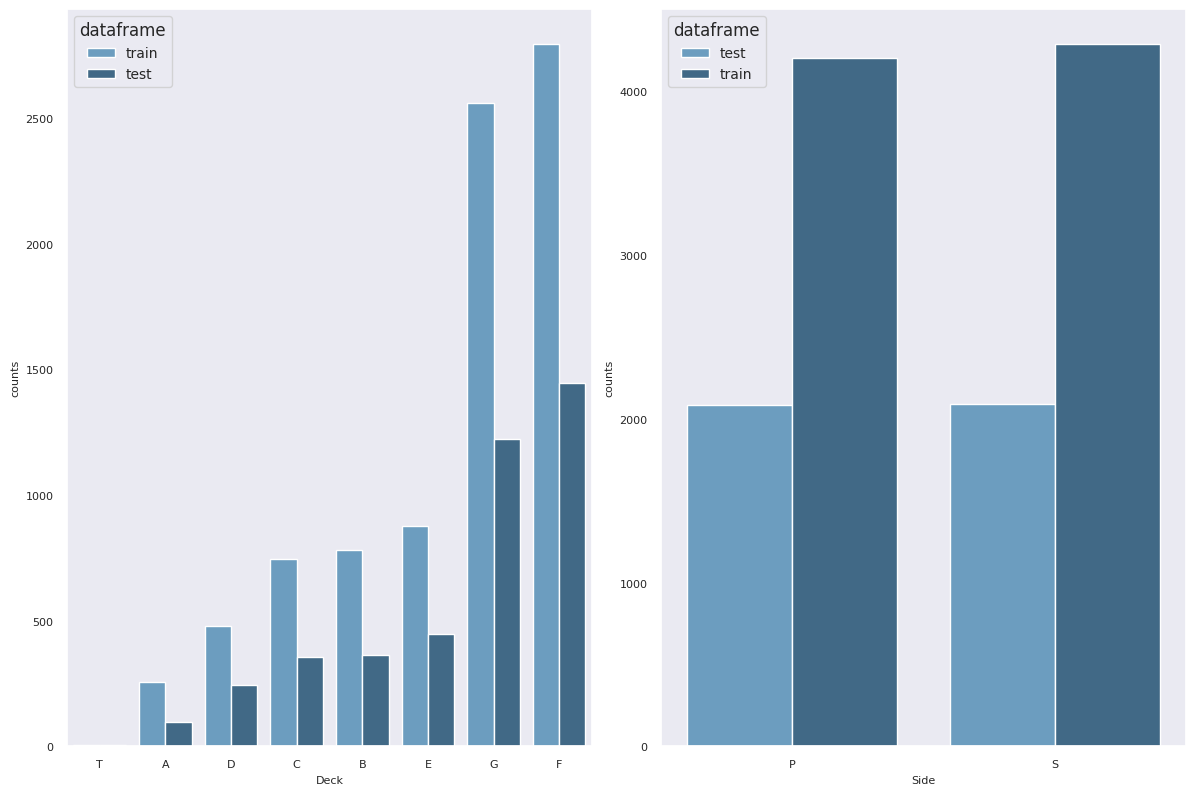

In [99]:
cols = ['Deck','Side']
cont=0
fig, axes = plt.subplots(figsize=(12,8), nrows=1, ncols=2)

x = (train_df.drop('Transported',axis=1)).copy()
x['dataframe']='train'
y = test_df.copy()
y['dataframe']='test'
z=pd.concat([x,y])
z[["Deck", "Cabin_num", "Side"]] = z["Cabin"].str.split("/", expand=True)

for i in range(2):
    column = cols[cont]
    df_gb = z.groupby([column,'dataframe']).size().reset_index(name='counts')
    df_gb = df_gb.sort_values(by='counts')
    sns.barplot(data=df_gb, y='counts', x=column, palette="Blues_d",ax=axes[i],hue='dataframe')

    cont+=1
fig.tight_layout()

plt.savefig('categorico2',dpi=300,bbox_inches='tight')

por ultimo, vemos que el problema de clasificación está balanceado.

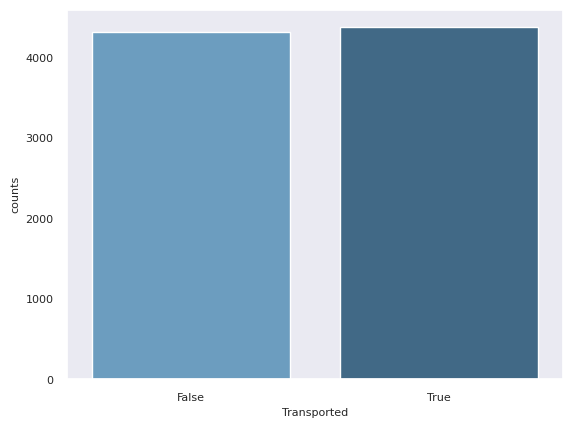

In [100]:
df_gb = train_df.groupby(['Transported']).size().reset_index(name='counts')
sns.barplot(data=df_gb, y='counts', x='Transported', palette="Blues_d")

plt.savefig('Transportedxd',dpi=300,bbox_inches='tight')

## Preprocesamiento

Primero, separemos Cabin y tratemos sus NaNs

In [101]:
train_df.loc[train_df['Cabin'].isna(),'Cabin']='?/?/?'
train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
# Convierte la columna 'C2' a tipo numérico y reemplaza '?' por NaN
train_df['Num'] = pd.to_numeric(train_df['Num'], errors='coerce')
test_df.loc[test_df['Cabin'].isna(),'Cabin']='?/?/?'
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)
# Convierte la columna 'C2' a tipo numérico y reemplaza '?' por NaN
test_df['Num'] = pd.to_numeric(test_df['Num'], errors='coerce')

Ahora, separamos el PassengerId en el grupo y su numero dentro del grupo. Además, calculamos el tamaño del grupo.

In [102]:
train_df[['Group', 'n']] = train_df['PassengerId'].str.split('_', expand=True)
train_df['n'] = pd.to_numeric(train_df['n'])
group_counts = train_df.groupby('Group')['n'].count().reset_index()
group_counts = group_counts.rename(columns={'n': 'GroupSize'})
train_df = pd.merge(train_df, group_counts, on='Group')

test_df[['Group', 'n']] = test_df['PassengerId'].str.split('_', expand=True)
test_df['n'] = pd.to_numeric(test_df['n'])
group_counts = test_df.groupby('Group')['n'].count().reset_index()
group_counts = group_counts.rename(columns={'n': 'GroupSize'})
test_df = pd.merge(test_df, group_counts, on='Group')

Para los continuos NaN, rellenamos con la media

In [103]:
cols_cont_conNa=['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Num']
for col in cols_cont_conNa:
    mean_conjunta=(pd.concat([train_df['Age'], test_df['Age']], axis=0, ignore_index=True)).mean()
    train_df.loc[train_df[col].isna(),col]=mean_conjunta
    test_df.loc[test_df[col].isna(),col]=mean_conjunta

Para los categoricos NaN, rellenamos con ?

In [104]:
cols_cat_conNa=['HomePlanet','CryoSleep','Destination','VIP']
for col in cols_cat_conNa:
    train_df.loc[train_df[col].isna(),col]='?'
    test_df.loc[test_df[col].isna(),col]='?'

Botemos los atributos que no usaremos

In [105]:
cols_drop = ['Name','Group','n','Cabin'] # El id lo necesitaremos para la submission
train_df = train_df.drop(cols_drop, axis=1)
test_df = test_df.drop(cols_drop, axis=1)

In [106]:
train_df['Transported'] = train_df['Transported'].astype(int)

Finalmente, hemos tratado todos los NaNs

In [107]:
train_df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Num             0
Side            0
GroupSize       0
dtype: int64

Finalmente, procedemos a hacer un escalamiento y codificación de los datos.

In [108]:
cont_scaler=MinMaxScaler()
cat_encoder=OneHotEncoder(sparse_output=False)
cont_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Num','GroupSize']
cat_features = ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side']
train_df[cat_features] = train_df[cat_features].astype(str)
test_df[cat_features] = test_df[cat_features].astype(str)
transformer = ColumnTransformer(
    transformers=[
        ('cont', cont_scaler, cont_features),
        ('cat', cat_encoder, cat_features)
    ],remainder='passthrough'
)
train = train_df.drop(['Transported','PassengerId'],axis=1)
y = train_df['Transported']
X_transformed = transformer.fit_transform(train)
scaled_df = pd.DataFrame(X_transformed, columns=transformer.get_feature_names_out())

In [109]:
scaled_df

,cont__Age,cont__RoomService,cont__FoodCourt,cont__ShoppingMall,cont__Spa,cont__VRDeck,cont__Num,cont__GroupSize,cat__HomePlanet_?,cat__HomePlanet_Earth,...,cat__Deck_B,cat__Deck_C,cat__Deck_D,cat__Deck_E,cat__Deck_F,cat__Deck_G,cat__Deck_T,cat__Side_?,cat__Side_P,cat__Side_S
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,0.000000,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,0.000000,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,0.000000,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,0.000528,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.518987,0.000000,0.228726,0.000000,0.073322,0.003066,0.051742,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8689,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,0.791447,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8690,0.329114,0.000000,0.000000,0.079687,0.000045,0.000000,0.791975,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8691,0.405063,0.000000,0.035186,0.000000,0.015753,0.134049,0.321014,0.142857,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Selección de modelo

Compararemos los modelos LogisticRegression, SVC, GradientBoosting y RandomForest.

Primero sin ningun tuning de hiperparametros

In [110]:
X_train,X_test,y_train,y_test=train_test_split(scaled_df,y,test_size=.1)
#modelos
lr = LogisticRegression()
svc = SVC()
grad=GradientBoostingClassifier()
rf =RandomForestClassifier()

lr.fit(X_train,y_train)
print('LogisticRegression train score:',lr.score(X_train,y_train))
print('LogisticRegression test score:',lr.score(X_test,y_test))

svc.fit(X_train,y_train)
print('SVC train score:',svc.score(X_train,y_train))
print('SVC test score:',svc.score(X_test,y_test))

grad.fit(X_train,y_train)
print('GradientBoosting train score:',grad.score(X_train,y_train))
print('GradientBoosting test score:',grad.score(X_test,y_test))

rf.fit(X_train,y_train)
print('RandomForest train score:',rf.score(X_train,y_train))
print('RandomForest test score:',rf.score(X_test,y_test))

LogisticRegression train score: 0.7723379777578934
LogisticRegression test score: 0.735632183908046
SVC train score: 0.7614725808513358
SVC test score: 0.7103448275862069
GradientBoosting train score: 0.8269206186884827
GradientBoosting test score: 0.7965517241379311
RandomForest train score: 0.999616515403298
RandomForest test score: 0.7735632183908046


A priori RandomForest es mejor en el conjunto de entrenamiento, pero muestra overfitting, pues su error en test es menor por un orden. Por tanto, GradientBoosting es mejor, además no muestra signo de overfitting.

Ahora, procedemos a hacer GridSearch en cada modelo, para encontrar una mejor combinación.

LogisticRegression:

In [111]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 100, 'penalty': 'l2'}
Test Accuracy: 0.7620689655172413


SVC:

In [112]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Parámetro de regularización
    'kernel': ['linear', 'rbf', 'poly'],  # Tipo de kernel
}


logreg = SVC()
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 100, 'kernel': 'poly'}
Test Accuracy: 0.7620689655172413


GradientBoosting:

In [113]:
param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [1,3,5,7],
}


grad = GradientBoostingClassifier()
grid_search = GridSearchCV(grad, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)

Best Parameters: {'max_depth': 3, 'n_estimators': 500}
Test Accuracy: 0.7885057471264367


RandomForest:

In [114]:
param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [1,3,5,7],
}


rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)

Best Parameters: {'max_depth': 7, 'n_estimators': 100}
Test Accuracy: 0.7620689655172413


Todos obtuvieron resultados parecidos, por lo que volveremos a elegir GradientBoosting

## Métricas y análisis de resultados

Para ver varias metricas, haremos un classification report

In [115]:
grad = GradientBoostingClassifier(n_estimators=100,max_depth=3)
grad.fit(X_train,y_train)
print('metricas en train:')
print(classification_report(y_train, grad.predict(X_train), target_names=['No Transportado','Transportado']))
print('metricas en test:')
print(classification_report(y_test, grad.predict(X_test), target_names=['No Transportado','Transportado']))

metricas en train:
                 precision    recall  f1-score   support

No Transportado       0.84      0.80      0.82      3897
   Transportado       0.81      0.85      0.83      3926

       accuracy                           0.83      7823
      macro avg       0.83      0.83      0.83      7823
   weighted avg       0.83      0.83      0.83      7823

metricas en test:
                 precision    recall  f1-score   support

No Transportado       0.79      0.78      0.79       418
   Transportado       0.80      0.81      0.81       452

       accuracy                           0.80       870
      macro avg       0.80      0.80      0.80       870
   weighted avg       0.80      0.80      0.80       870



para ver errores tipo 1 y 2, veamos la matrices de confusion.

matriz de confusion en train:


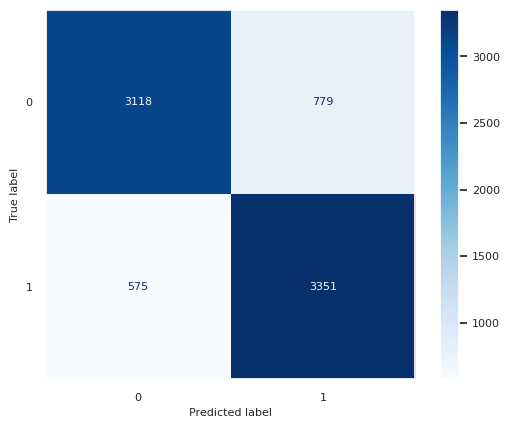

In [116]:
print('matriz de confusion en train:')
cm = confusion_matrix(y_train.values, grad.predict(X_train.values), labels=grad.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grad.classes_)
disp.plot(cmap = "Blues")
plt.savefig('confusion1',dpi=300,bbox_inches='tight')

matriz de confusion en test:


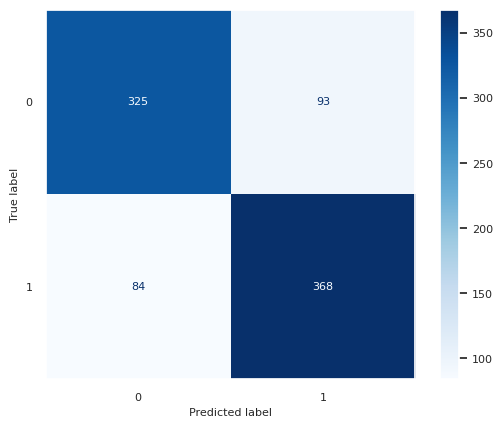

In [117]:
print('matriz de confusion en test:')
cm = confusion_matrix(y_test.values, grad.predict(X_test.values), labels=grad.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grad.classes_)
disp.plot(cmap = "Blues")
plt.savefig('confusion2',dpi=300,bbox_inches='tight')

## Visualizaciones del modelo

Primero, haremos un PCA con n igual a 2 y 3.

Para intentar visualizar el modelo, veamos el arbol 99 que generó GradientBoosting,

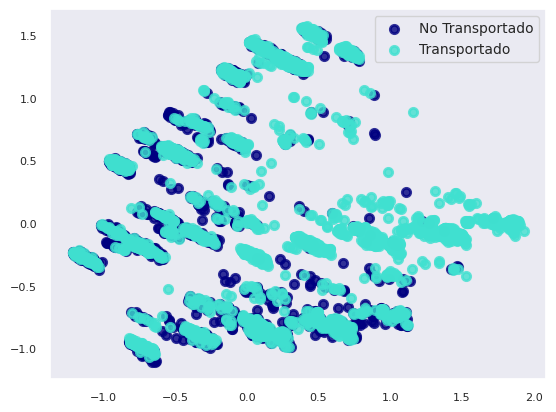

In [118]:
pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)
target_names=['No Transportado','Transportado']
plt.figure()
colors = ["navy", "turquoise"]
lw = 2
y = y_train
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.savefig('PCA2',dpi=300,bbox_inches='tight')

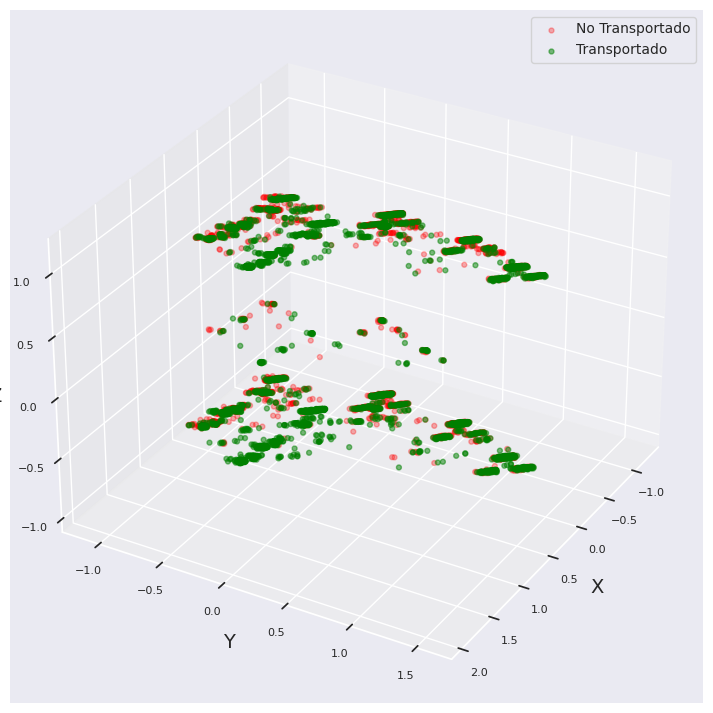

In [119]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_pca = pca.transform(X_train)

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio


Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

cdict = {0:'red',1:'green'}
labl = {0:'No Transportado',1:'Transportado'}
marker = {0:'.',1:'.'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=50,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.set_zlabel("Z", fontsize=14)

ax.legend()
ax.view_init(30, 30, 0)
plt.savefig('PCA3',dpi=300,bbox_inches='tight')

Vemos que en ambos casos, el conjunto no es separable.

Sabemos que GradientBoosting genera arboles de manera secuencial. Por lo que, podemos observar el arbol 99:

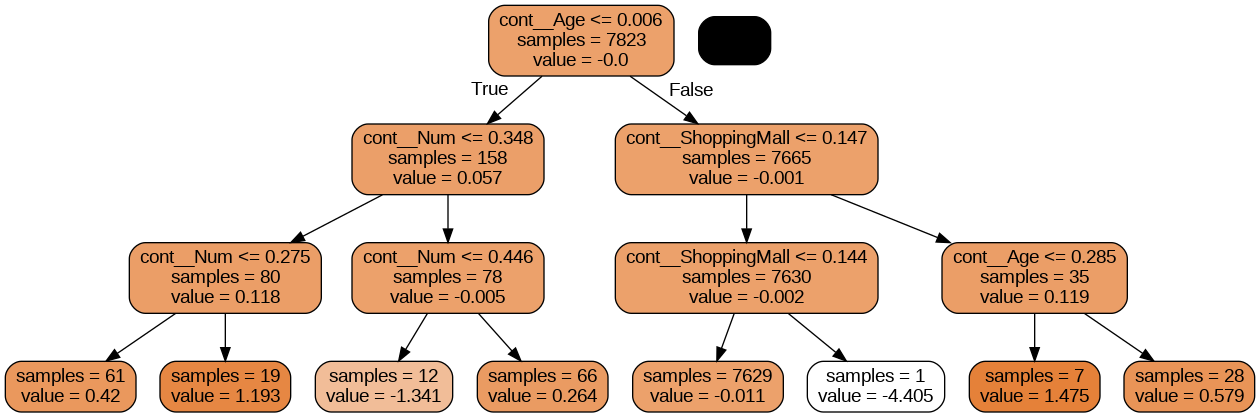

In [ ]:
sub_tree_42 = grad.estimators_[99,0]
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,feature_names = X_train.columns,
                              class_names = ['Negative', 'Positive']
    ,out_file=None, filled=True, rounded=True,

    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('arbolito.png').write_bytes(png)
# Display0
Image(png)

Vemos que el arbol parte con la edad, la parte izquierda del Arbol se enfoca en el numero del atributo Cabin y la derecha ve los gastos en ShoppingMall.

## Conclusiones

* En este proyecto, atacamos un problema de clasificación de inicio a fin
* Aplicamos todo lo visto en el curso
* Comparamos 4 modelos, LogisticRegression, SVC, GradientBoosting y RandomForest, nos quedamos con GradientBoosting pues mostro buen desempeño sin tunear hiperparametros y tambien considerando la maximizacion de estos.
* Conseguimos un clasificador consistente
* Subimos al Kaggle la siguiente submission obteniendo un Score: 0.80476

In [ ]:
x_test_transform = pd.DataFrame(transformer.transform(test_df.drop('PassengerId',axis=1)), columns=transformer.get_feature_names_out())

In [ ]:
y_pred = grad.predict(x_test_transform)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Transported':y_pred.astype(bool)})

In [ ]:
submission.to_csv('submission_proyecto_2.csv',index=False)